# Libs

In [1]:
# base
import time
import re
import numpy as np
import matplotlib.pyplot as plt

# tensorflow
import tensorflow_datasets as tfds

import tensorflow as tf
from tensorflow.keras import layers

# telegram
from telegram.ext import Updater, CommandHandler, MessageHandler, Filters

# Loading data

In [2]:
from my_funcs.scr import read_file

text = read_file('../data/Otvety.txt', duration=True)

in 70 sec.


# Preprocessing data

### Corpus

In [3]:
def preprocess_text(w):
    w = re.sub('\n', '', w)
    w = re.sub('---', '', w)
    w = re.sub(':\)', '', w)
    w = re.sub('\/+', '', w)
    w = re.sub('[();"]', '', w)
    w = re.sub('<[^>]+>', ' ', w)
    
    w = re.sub('\s*\?\s*\.', '?', w)
    w = re.sub('\s*\!\s*\.', '!', w)
    w = re.sub('\s*\.', '.', w)
    w = re.sub('\.+', '.', w)
    
    return w

In [4]:
NUM_EXAMPLES = 1_600_000
corpus = preprocess_text(text[:NUM_EXAMPLES])
print(corpus[:1000])

вопрос о ТДВ давно и хорошо отдыхаем ЛИЧНО ВАМ здесь кого советовали завести? хомячка. мужика, йопаря, собачку и 50 кошек. Общение! паучка. Да пол мне бы памыть! А таг то ни чо. Типа ни каво! я тут вообще что бы пообщаться. А мне советовали сиси завести. Ну, слава богу, мужика завести ещё не советовали А вот сватать к кому только не сватали. мне тут советовали завести любовника, мужа и много кошек  приветик. Как парни относятся к цветным линзам? Если у девушки то зеленые глаза, то голубые. меня вобще прикалывает эта тема. когда этобыло редкость - было забавно, а когда все знают, что эта фальшивка, то уже не прикольно, как силиконовые сиськи или как налепленные синтетические волосы. Что делать, сегодня нашёл 2 миллиона рублей? Если это счастье  действительно на вас свалилось, лучше пойти в милицию и заявить о находке. Такие деньги просто так не терют, а что самое интересное их неприменно будут искать и поверьте мне найдут, видел подобное в жизни. Можно нарваться на бабушку конечно, кото

### Sentenses

In [5]:
def split_by_sentence(text):
    sent = re.findall('[^?!.]+.', text)
    sent = [s.strip() for s in sent]
    return sent

In [6]:
sentences = split_by_sentence(corpus)
sentences[:5]

['вопрос о ТДВ давно и хорошо отдыхаем ЛИЧНО ВАМ здесь кого советовали завести?',
 'хомячка.',
 'мужика, йопаря, собачку и 50 кошек.',
 'Общение!',
 'паучка.']

### Tokenize

In [7]:
from my_funcs.scr import split_by_subwords

try:
    tokenizer_en = tfds.deprecated.text.SubwordTextEncoder.load_from_file('tokenizer_en')
    print('tokenizer_en loaded')
except UnicodeDecodeError:
    tokenizer_en = split_by_subwords(
        corpus_generator=(sent for sent in sentences),
        file_name='tokenizer_en')

tokenizer_en loaded


### Emdending tokens

In [8]:
pangram = 'Съешь же ещё этих мягких французских булок, да выпей чаю.'

tokenized_string = tokenizer_en.encode(pangram)
original_string = tokenizer_en.decode(tokenized_string)

print(original_string)
for ts in tokenized_string:
    print (f'{ts}\t----> {tokenizer_en.decode([ts])}')

Съешь же ещё этих мягких французских булок, да выпей чаю.
121	----> С
2204	----> ъе
280	----> шь 
70	----> же 
314	----> ещё 
2331	----> этих 
3853	----> мягки
28	----> х 
7407	----> француз
1156	----> ских 
6593	----> бул
237	----> ок
1	----> , 
154	----> да 
1285	----> вып
102	----> ей 
6752	----> чаю
8136	----> .


In [9]:
MAX_LEN = 16

sequence = [tokenizer_en.encode(sent) for sent in sentences]
sequence = tf.keras.preprocessing.sequence.pad_sequences(sequence, padding='post')
sequence = sequence[:, :MAX_LEN+1]
sequence = sequence.astype('int64')
sequence = sequence[sequence[:, 1] != 0]

print(sequence.shape)
sequence

(27864, 17)


array([[ 819,   20,  248, ..., 1421,  972,  548],
       [ 556, 1164, 1658, ...,    0,    0,    0],
       [1275,   12,    1, ..., 8136,    0,    0],
       ...,
       [  72, 5776, 8122, ..., 7958,  130,    1],
       [ 209,    4, 2045, ..., 4991,  225,  494],
       [  12,   15,  763, ...,    0,    0,    0]], dtype=int64)

### Dataset

In [10]:
def split_input_target(chunk):
    return chunk, chunk[1:]

def encode(tar, inp):
    tar = [tokenizer_en.vocab_size] + list(tar.numpy()) + [tokenizer_en.vocab_size+1]
    inp = [tokenizer_en.vocab_size] + list(inp.numpy()) + [tokenizer_en.vocab_size+1]
    return tar, inp

def tf_encode(tar, inp):
    tar, inp = tf.py_function(func=encode, inp=[tar, inp], Tout=[tf.int64, tf.int64])
    tar.set_shape([None])
    inp.set_shape([None])
    return tar, inp

In [11]:
BUFFER_SIZE = 20_000
BATCH_SIZE = 64

start = time.time()

dataset = tf.data.Dataset.from_tensor_slices(sequence)
dataset = dataset.map(split_input_target)
dataset = dataset.map(tf_encode)
dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.padded_batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

print(next(iter(dataset)))
print(f'in {round(time.time() - start)} sec.')

(<tf.Tensor: shape=(64, 19), dtype=int64, numpy=
array([[8346, 6959, 8123, ...,    0,    0, 8347],
       [8346, 7252, 1868, ...,    0,    0, 8347],
       [8346, 2305, 4833, ...,    7, 2005, 8347],
       ...,
       [8346,  295, 5058, ...,    0,    0, 8347],
       [8346,  709,   91, ..., 1514,  358, 8347],
       [8346, 5303, 8122, ...,  318, 4108, 8347]], dtype=int64)>, <tf.Tensor: shape=(64, 18), dtype=int64, numpy=
array([[8346, 8123,    0, ...,    0,    0, 8347],
       [8346, 1868, 5352, ...,    0,    0, 8347],
       [8346, 4833, 8122, ...,    7, 2005, 8347],
       ...,
       [8346, 5058, 8122, ...,    0,    0, 8347],
       [8346,   91,  260, ..., 1514,  358, 8347],
       [8346, 8122, 4648, ...,  318, 4108, 8347]], dtype=int64)>)
in 23 sec.


In [12]:
for tar, inp in dataset.take(1):
    print(tokenizer_en.decode(tar[0][1:-2]))
    print(tokenizer_en.decode(inp[0][1:-2]))

нЕЕЕЕТЬ, нас ппяяттеро!
ЕЕЕЕТЬ, нас ппяяттеро!


# Create model

### Encoder & Decoder layers

(1, 50, 512)


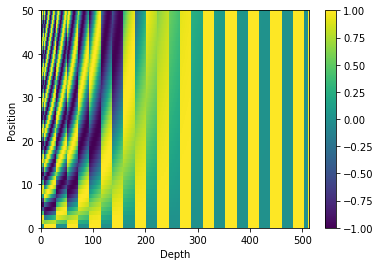

In [13]:
from my_layers.encoder_decoder import positional_encoding, point_wise_feed_forward_network, Encoder, Decoder

pos_encoding = positional_encoding(50, 512)
print (pos_encoding.shape)

plt.pcolormesh(pos_encoding[0])
plt.xlabel('Depth')
plt.xlim((0, 512))
plt.ylabel('Position')
plt.colorbar()
plt.show()

### Transformer

In [14]:
class Transformer(tf.keras.Model):
    """
    sample_transformer = Transformer(num_layers=2, d_model=512, num_heads=8, dff=2048, 
                                     input_vocab_size=8500, target_vocab_size=8000, 
                                     pe_input=10000, pe_target=6000)

    temp_input = tf.random.uniform((64, 38), dtype=tf.int64, minval=0, maxval=200)
    temp_target = tf.random.uniform((64, 36), dtype=tf.int64, minval=0, maxval=200)

    fn_out, _ = sample_transformer(temp_input, temp_target, training=False, 
                                   enc_padding_mask=None, 
                                   look_ahead_mask=None,
                                   dec_padding_mask=None)

    fn_out.shape  # (batch_size, tar_seq_len, target_vocab_size)
    
    out: TensorShape([64, 36, 8000])
    """
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, target_vocab_size, pe_input, pe_target, rate=0.1):
        super(Transformer, self).__init__()
        
        self.encoder = Encoder(num_layers, d_model, num_heads, dff, input_vocab_size, pe_input, rate)
        self.decoder = Decoder(num_layers, d_model, num_heads, dff, target_vocab_size, pe_input, rate)
        
        self.final_layer = layers.Dense(target_vocab_size)
        
    def call(self, inp, tar, training, enc_padding_mask, look_ahead_mask, dec_padding_mask):
        enc_output = self.encoder(inp, training, enc_padding_mask)
        dec_output, attention_weights = self.decoder(tar, enc_output, training, look_ahead_mask, dec_padding_mask)
        final_output = self.final_layer(dec_output)
        return final_output, attention_weights

## Hyperparameters

In [15]:
num_layers = 4
d_model = 128
dff = 512
num_heads = 8

input_vocab_size = tokenizer_en.vocab_size + 2
target_vocab_size = tokenizer_en.vocab_size + 2
dropout_rate = 0.1

## Optimizer

In [16]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4_000):
        super(CustomSchedule, self).__init__()
        
        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps
        
    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)
        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [17]:
learning_rate = CustomSchedule(d_model)
optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

Text(0.5, 0, 'Train Step')

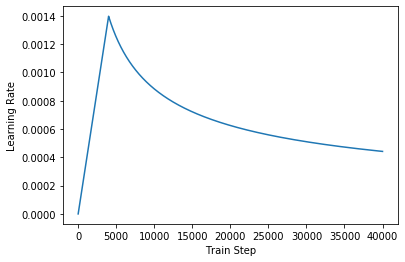

In [18]:
temp_learning_rate_schedule = CustomSchedule(d_model)

plt.plot(temp_learning_rate_schedule(tf.range(40000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

## Loss and metrics

In [19]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.Mean(name='train_accuracy')

In [20]:
def loss_function(real, pred):
    loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')
    loss = loss_object(real, pred)
    
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    mask = tf.cast(mask, dtype=loss.dtype)
    
    loss *= mask
    loss = tf.reduce_sum(loss) / tf.reduce_sum(mask)
    return loss

def accuracy_function(real, pred):
    acc = tf.equal(real, tf.argmax(pred, axis=2))
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    
    acc = tf.math.logical_and(mask, acc)
    acc = tf.cast(acc, dtype=tf.float32)
    mask = tf.cast(mask, dtype=tf.float32)
    
    acc = tf.reduce_sum(acc) / tf.reduce_sum(mask)
    return acc

## Model init

In [21]:
transformer = Transformer(
    num_layers, d_model, num_heads, dff,
    input_vocab_size, target_vocab_size, 
    pe_input=input_vocab_size,
    pe_target=target_vocab_size,
    rate=dropout_rate
)

## Checkpointing

In [22]:
checkpoint_path = "./checkpoints/train"

ckpt = tf.train.Checkpoint(
    transformer=transformer,
    optimizer=optimizer
)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print ('Latest checkpoint restored!!')

Latest checkpoint restored!!


## Training

In [23]:
from my_funcs.masking import create_masks

def train_step(inp, tar):
    tar_inp = tar[:, :-1]
    tar_real = tar[:, 1:]
    
    enc_padding_mask, combine_mask, dec_padding_mask = create_masks(inp, tar_inp)

    with tf.GradientTape() as tape:
        pred, _ = transformer(
            inp, tar_inp, True,
            enc_padding_mask,
            combine_mask,
            dec_padding_mask
        )
        loss = loss_function(tar_real, pred)
        
    grad = tape.gradient(loss, transformer.trainable_variables)
    optimizer.apply_gradients(zip(grad, transformer.trainable_variables))
    
    train_loss(loss)
    train_accuracy(accuracy_function(tar_real, pred))

In [24]:
EPOCHS = 1
training = True

if training:
    for epoch in range(EPOCHS):
        start = time.time()

        train_loss.reset_states()
        train_accuracy.reset_states()

        for batch, (tar, inp) in enumerate(dataset):
            train_step(inp, tar)
        
        print (f'Epoch {epoch + 1} Loss {train_loss.result():.4f} Accuracy {train_accuracy.result():.4f}')
        print (f'Time taken for 1 epoch: {round(time.time() - start)} secs')
        ckpt_manager.save()
        print (f'Saving checkpoint for epoch {epoch+1}\n')

Epoch 1 Loss 0.2932 Accuracy 0.9433
Time taken for 1 epoch: 165 secs
Saving checkpoint for epoch 1



## Eval

In [25]:
def evaluate(inp_sentence):
    start_token = [tokenizer_en.vocab_size]
    end_token = [tokenizer_en.vocab_size + 1]
    
    inp_sentence = start_token + tokenizer_en.encode(inp_sentence) + end_token
    encoder_input = tf.expand_dims(inp_sentence, 0)

    decoder_input = [tokenizer_en.vocab_size]
    output = tf.expand_dims(decoder_input, 0)

    for i in range(MAX_LEN):
        enc_padding_mask, combined_mask, dec_padding_mask = create_masks(encoder_input, output)

        predictions, attention_weights = transformer(
            encoder_input, output, False,
            enc_padding_mask, combined_mask, dec_padding_mask
        )
        predictions = predictions[:, -1:, :]
        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

        if predicted_id == tokenizer_en.vocab_size+1:
            return tf.squeeze(output, axis=0), attention_weights

        output = tf.concat([output, predicted_id], axis=-1)

    return tf.squeeze(output, axis=0), attention_weights

In [26]:
def text_generator(sentence):
    result, attention_weights = evaluate(sentence)
    predicted_sentence = tokenizer_en.decode([i for i in result if i < tokenizer_en.vocab_size - 1])
    
    print(f'Input: {sentence}')
    print(f'Predicted message: {predicted_sentence}')
    return predicted_sentence

In [27]:
text_generator('Привет')

Input: Привет
Predicted message: — Приветnn.


'— Приветnn.'

# Connection

In [28]:
updater = Updater(token=read_file('./token.txt'))
dispatcher = updater.dispatcher

# Command processing

In [29]:
def answer(update, context):
    context.bot.send_message(chat_id=update.effective_chat.id, text=text_generator(update.message.text))

In [30]:
answer_handler = MessageHandler(Filters.text, answer)
dispatcher.add_handler(answer_handler)

In [31]:
chat = True

if chat:
    updater.start_polling()
    print("Bot \"40in\" is on")
else:
    updater.stop()
    print("Bot \"40in\" is off")

Bot "40in" is on


# Sources:
- https://github.com/python-telegram-bot/python-telegram-bot/wiki/Extensions-%E2%80%93-Your-first-Bot